In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import methods
from importlib import reload

In [3]:
nside = 1024
lmax = 3 * nside-1
# m_out = 1e6 * hp.ud_grade(hp.read_map('npipe6v20_sim/0200/npipe6v20_143_map.fits', field=None), nside)
m_res = 1e6 * hp.ud_grade(hp.read_map('npipe6v20_sim/res/residual_npipe6v20_143_0200.fits', field=None), nside)
# noise_fix = hp.read_map('npipe6v20_sim/0200/noisefix/noisefix_143_0200.fits', field=None)
alm = [hp.read_alm('npipe6v20_sim/input/ffp10_cmb_143_alm_mc_0200.fits', hdu=i) for i in range(1,4)]
m_in = 1e6 * hp.alm2map(alm, nside)

In [4]:
ells = np.arange(lmax+1)
c2d = ells* (ells+1)/np.pi/2

In [5]:
# out = c2d*hp.anafast(m_out)
# cl_in = c2d*hp.anafast(m_in)
res = c2d*hp.anafast(m_res)

[]

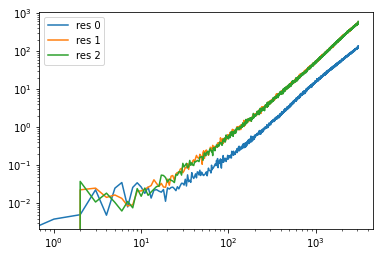

In [6]:
for i in range(3):
    # plt.plot(out[i], label=f'out {i}')
    # plt.plot(cl_in[i], label=f'cl_in {i}')
    plt.plot(res[i], label=f'res {i}')
plt.legend()
plt.loglog()
# plt.plot(TT)
# plt.ylim([1e-3, 1e4])

In [7]:
ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)


# plt.loglog(cl_in[0])

# plt.loglog(TT)
# plt.ylim([1e1, 1e4])

In [8]:
def depth2nl(map_depth, beam_fwhm, lmax):
    ell = np.arange(lmax+1)
    return map_depth**2 * np.exp(ell*(ell+1) * beam_fwhm **2 / 8/np.log(2))

In [9]:
t_nl = c2d*depth2nl(25*np.pi/(60*180), np.deg2rad(10/60), lmax=lmax)
p_nl = c2d*depth2nl(50*np.pi/(60*180), np.deg2rad(10/60), lmax=lmax)
omg = c2d*depth2nl(10*np.pi/(60*180), np.deg2rad(19/60), lmax=lmax)
f = c2d*depth2nl(5*np.pi/(60*180), np.deg2rad(19/60), lmax=lmax)

(2, 4000.0)

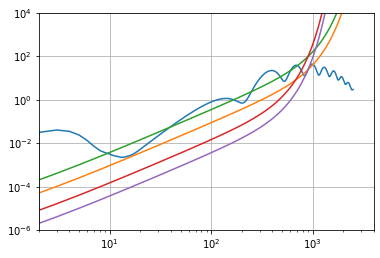

In [10]:
# plt.plot(res[0])
# plt.plot(res[1])
plt.plot(EE)
plt.plot(t_nl)
plt.plot(p_nl)
plt.plot(omg)
plt.plot(f)
plt.loglog()
plt.grid()
plt.ylim([1e-6, 1e4])
plt.xlim([2,4e3])

In [11]:
n_sims = 10

In [12]:
a_res_vector = np.empty((n_sims, 3, lmax+1))

In [13]:
for i in range(n_sims):
    m_res = 1e6 * hp.ud_grade(hp.read_map(f'npipe6v20_sim/res/residual_npipe6v20_143_020{i}.fits', field=None), nside)
    a_res_vector[i] = hp.anafast(m_res, nspec=3)

In [14]:
mean_res = np.mean(a_res_vector, axis=0)
log_mean_res = np.log(mean_res)
log_mean_res[np.isinf(log_mean_res)]=0

/tmp/ipykernel_47737/2644174153.py:2: RuntimeWarning: divide by zero encountered in log
  log_mean_res = np.log(mean_res)


In [14]:
ells = np.arange(lmax+1)
log_ells = np.log(ells)
log_ells[np.isinf(log_ells)]=0

/tmp/ipykernel_46375/3656386107.py:2: RuntimeWarning: divide by zero encountered in log
  log_ells = np.log(ells)


In [15]:
from scipy.optimize import curve_fit

In [16]:
def log_noise_model(l, n, knee, alpha):
    return np.log(n* (np.exp(l)/knee)**alpha + n)

def noise_model(l, n, knee, alpha):
    return n* (l/knee)**alpha + n

In [17]:
params_TT ,_= curve_fit(log_noise_model, log_ells, log_mean_res[0])
params_EE ,_= curve_fit(log_noise_model, log_ells, log_mean_res[1])
params_BB ,_= curve_fit(log_noise_model, log_ells, log_mean_res[2])

/tmp/ipykernel_46375/1329487488.py:2: RuntimeWarning: invalid value encountered in log
  return np.log(n* (np.exp(l)/knee)**alpha + n)


In [18]:
# np.save('noise_fit_T', params_TT)
# np.save('noise_fit_P', params_EE)

In [26]:
params_TT[0]

9.07425537973659e-05

In [29]:
params_EE

array([ 3.48820696e-04,  1.14849716e+01, -2.82561172e+00])

In [84]:
reload(methods)
Nl_T = methods.get_Nl(30, 50, -1.8, lmax)
Nl_P = methods.get_Nl(60, 20, -1.4, lmax) 

/scratch/yuyang/destripe/methods.py:70: RuntimeWarning: divide by zero encountered in power
  model = n * (l/knee)**alpha + n


[]

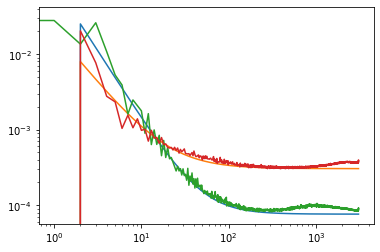

In [85]:
plt.plot(Nl_T)
plt.plot(Nl_P)
plt.plot(mean_res[0])
plt.plot(mean_res[1])
plt.loglog()

In [19]:
#Translate white noise level to map depth (uk arcmin)
np.sqrt(params_TT[0]) * (180*60)/np.pi 

32.74759280558176

In [20]:
np.sqrt(params_EE[0]) * (180*60)/np.pi 

64.20590987524697

/tmp/ipykernel_46375/1329487488.py:5: RuntimeWarning: divide by zero encountered in power
  return n* (l/knee)**alpha + n


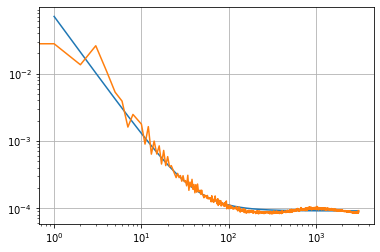

In [21]:
plt.plot(ells, noise_model(ells, params_TT[0], params_TT[1], params_TT[2]))
plt.plot(ells, mean_res[0])
plt.loglog()
plt.grid()

/tmp/ipykernel_46375/1329487488.py:5: RuntimeWarning: divide by zero encountered in power
  return n* (l/knee)**alpha + n


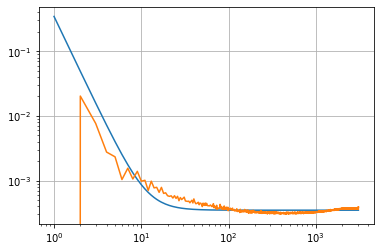

In [22]:
plt.plot(ells, noise_model(ells, params_EE[0], params_EE[1], params_EE[2]))
plt.plot(ells, mean_res[1])
plt.loglog()
plt.grid()

/tmp/ipykernel_46375/1329487488.py:5: RuntimeWarning: divide by zero encountered in power
  return n* (l/knee)**alpha + n


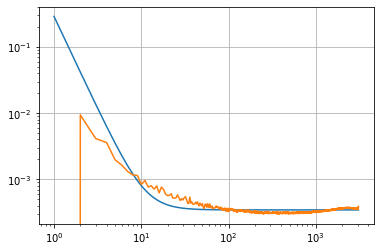

In [23]:
plt.plot(ells, noise_model(ells, params_BB[0], params_BB[1], params_BB[2]))
plt.plot(ells, mean_res[2])
plt.loglog()
plt.grid()

/tmp/ipykernel_46375/1329487488.py:5: RuntimeWarning: divide by zero encountered in power
  return n* (l/knee)**alpha + n
/tmp/ipykernel_46375/3797812016.py:1: RuntimeWarning: invalid value encountered in multiply
  plt.plot(ells, c2d*noise_model(ells, params_TT[0], params_TT[1], params_TT[2]))


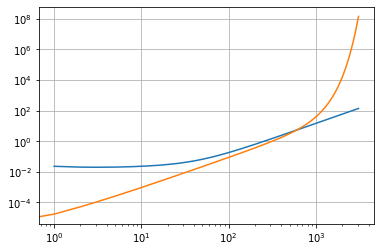

In [24]:
plt.plot(ells, c2d*noise_model(ells, params_TT[0], params_TT[1], params_TT[2]))
# plt.plot(ells, c2d*mean_res[1])
plt.plot(t_nl)
# plt.plot(p_nl)
plt.loglog()
plt.grid()